In [1]:
import functions
import networkx as nx
import numpy as np
import osmnx as ox

/home/jdiego/anaconda3/envs/ox/lib/python3.11/site-packages/osmnx/simplification.py:542: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '22-0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gdf.loc[idx, "cluster"] = f"{cluster_label}-{suffix}"


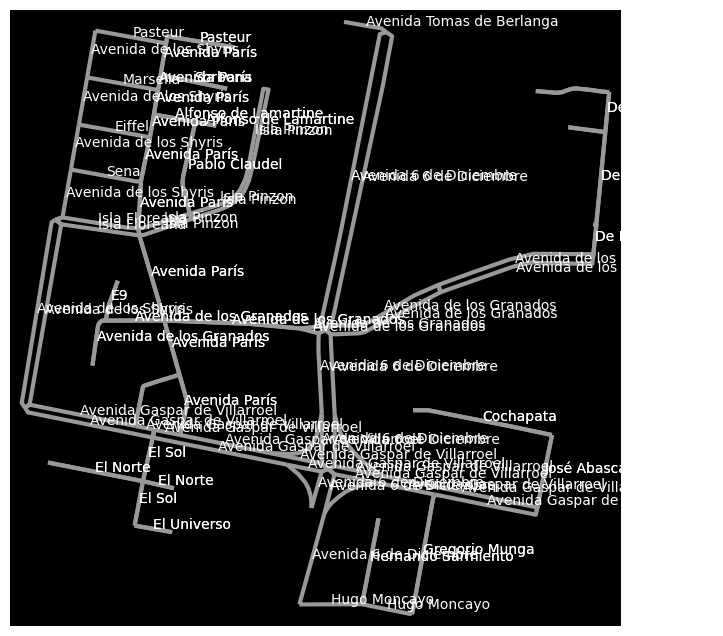

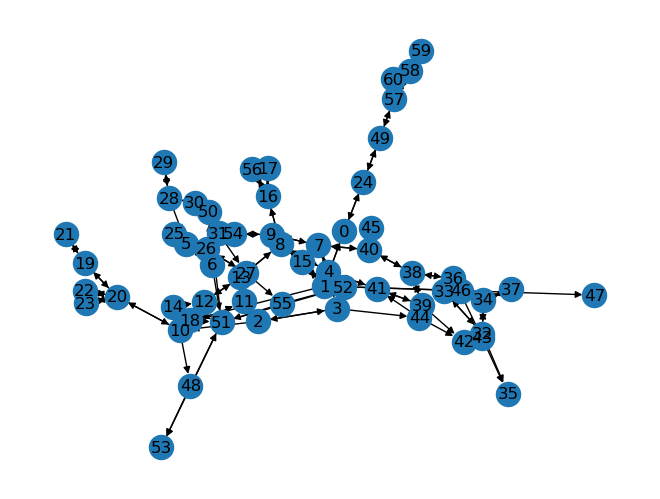

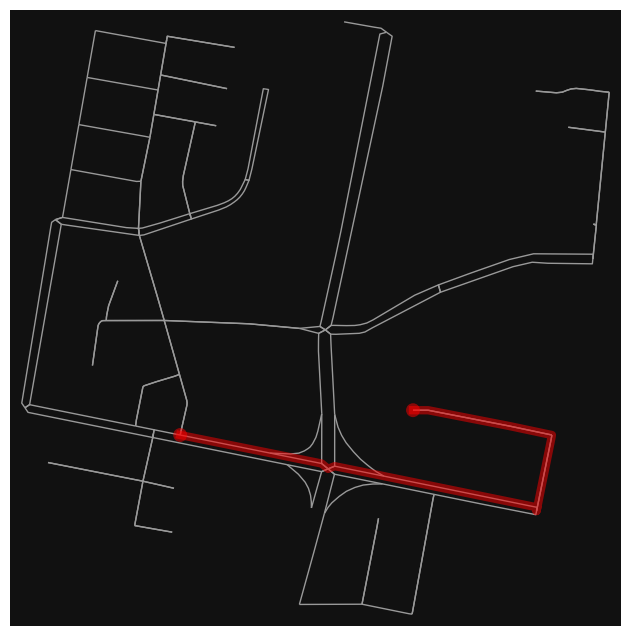

In [21]:
# Get the map 
G3 = functions.get_node(-0.16916, -78.47632, 400)

# plot the netwrok
nx.draw(G3, with_labels=True)

#[12, 13, 12, 10, 48, 51, 52, 1, 18, 51]

# Ploting just the nodes  
#route0_G3 = nx.shortest_path(G3, 12, 12)
#route1_G3 = nx.shortest_path(G3, 50, 50)
#route2_G3 = nx.shortest_path(G3, 26, 26)
#route3_G3 = nx.shortest_path(G3, 27, 27)
#route4_G3 = nx.shortest_path(G3, 55, 55)
#route5_G3 = nx.shortest_path(G3, 52, 52)
#route6_G3 = nx.shortest_path(G3, 1, 1)
#routes_G3 = [route0_G3 , route1_G3]#,route2_G3,route3_G3,route4_G3,route5_G3,route6_G3]

#fig, ax = ox.plot_graph_routes(G3, routes_G3, route_linewidth=6, node_size=0)

# plot route from node 2 to node 10 
route00_G3 = nx.shortest_path(G3, 25, 12)  # 12-45 ya salio  # 12-54 ya salio  # 25-54

#Plot routes  
fig, ax = ox.plot_graph_route(G3, route00_G3, route_linewidth=6, node_size=0)

In [22]:
# def simulation function 

# get list of nodes 
list_nodes = list(G3.nodes)

# get dictionary with geocordinates of each of the nodes 

coordiantes = functions.get_geo_coordinates( G3 )

# defining initial and final node
initial_node = list_nodes[25]
final_node = list_nodes[12]

# loop to finde the path: 

node_i = initial_node 

# to store the route:
route = {}

path = []

# bug list
bug_list = []

# no exit list 
no_exit_list = []


while node_i != final_node:
    
    # measure the angle and distnac between the node_i and the destination node
    angle_i = functions.get_angle( coordiantes[ node_i ], coordiantes[ final_node] )
    dist_i = functions.get_distance( coordiantes[ node_i ], coordiantes[ final_node] ) 

    # get the neighbours of the node. The neighbours are directed nodes
    neighbors = list(G3.neighbors(node_i))


    # get probality of pick a given neighbour
    factors2 = {}
    

    # store all nodes the agent pass through: 
    path.append(node_i)

    for node in neighbors :
        # measure angle and dist of neighbors towards final node 
        angle_neighbor = functions.get_angle( coordiantes[ node ], coordiantes[ final_node] )
        dist_neighbor = functions.get_distance( coordiantes[ node ], coordiantes[ final_node] )

        # calculate the probability of picking a node 
        factors2[node] = functions.get_factor(dist_neighbor , angle_neighbor , dist_i , angle_i )

    # get probabilities
    proba_dic = functions.get_probability(factors2)


    print("estoy en el nodo  ", node_i, " mis opciones son : ", proba_dic)

    # list of probable nodes_id: 
    list_proba = list(proba_dic.keys())


    # chequear que no se cree un loop entre nodos
    repeticions = path.count(node_i)

    # if i pass throug this node 2 times then reduce the probability
    if repeticions == 2:
        if path[-2] in list(proba_dic.keys()):
            proba_dic[path[-2]]= proba_dic[path[-2]]*0.4
            print("ya pasee por ", proba_dic[path[-2]] , "voy  a actualizar su probabilidad a:" ,proba_dic)
        else:
            #print("no es posible regresar a: " ,path[-2])
            pass 

    if repeticions > 2:

        # sotre node_i in wich bug is produced 
        bug_node = node_i

        # reduzco a 0 la probabiliad del primer nodo vecino que presente un bug:
        #proba_dic[path[-2]]= proba_dic[path[-2]]*0.0

        # lo agrego a la lista the vecinos que prooducen bugs
        bug_list.append(path[-2])

        #check
        print("bugg en el nodo : " , bug_node )
        print("los vecinos que producen bug son: " ,bug_list)
        
        # lopp to upadte probabilities of neighbors that produce bugs 
        for key in list(proba_dic.keys()):
            if key in bug_list:
                proba_dic[key] = 0.0 
        print(proba_dic)

    # check for node with no exit i.e no neigbors 
    if len(neighbors) == 0:
        
        # store in route 
        route[node_i] = {}
        no_exit_node = node_i
        no_exit_list.append(no_exit_node)
        print("estoy en el nodo " , no_exit_node , "no hay salida")

        # update node_i to the previous node
        node_i = routes[-1]
        print("regreso a " , node_i)

        #check neighbors:
        neigbors_j = list(G3.neighbors(node_i))
        print(neigbors_j)

        # lopp to updte probabilities 
        for key in neigbors_j:
            if key in no_exit_list:
                print(key)
                proba_dic = route[node_i]
                proba_dic[key] = 0.0
        print(proba_dic)
        #break

    # stop simulation if bug 
    if repeticions > 5:
        print(" ERROR !!!")
        break

    # add to route:
    route[node_i] = proba_dic
    print("las proabilidades a considerar son: " , proba_dic)

    # store route: 
    routes= list(route.keys())

    # ge the node id with max probability
    node_id = max(proba_dic , key= proba_dic.get)

    # get the max probability    
    Proba = proba_dic[node_id]
        
    print("estoy en el nodo: " , node_id, "su probabilidad fue de: " , Proba )

    # update position
    node_i = node_id


estoy en el nodo   25  mis opciones son :  {26: 1.0}
las proabilidades a considerar son:  {26: 1.0}
estoy en el nodo:  26 su probabilidad fue de:  1.0
estoy en el nodo   26  mis opciones son :  {25: 0.7090696912808634, 27: 0.2909303087191366}
las proabilidades a considerar son:  {25: 0.7090696912808634, 27: 0.2909303087191366}
estoy en el nodo:  25 su probabilidad fue de:  0.7090696912808634
estoy en el nodo   25  mis opciones son :  {26: 1.0}
ya pasee por  0.4 voy  a actualizar su probabilidad a: {26: 0.4}
las proabilidades a considerar son:  {26: 0.4}
estoy en el nodo:  26 su probabilidad fue de:  0.4
estoy en el nodo   26  mis opciones son :  {25: 0.7090696912808634, 27: 0.2909303087191366}
ya pasee por  0.2836278765123454 voy  a actualizar su probabilidad a: {25: 0.2836278765123454, 27: 0.2909303087191366}
las proabilidades a considerar son:  {25: 0.2836278765123454, 27: 0.2909303087191366}
estoy en el nodo:  27 su probabilidad fue de:  0.2909303087191366
estoy en el nodo   27  mis

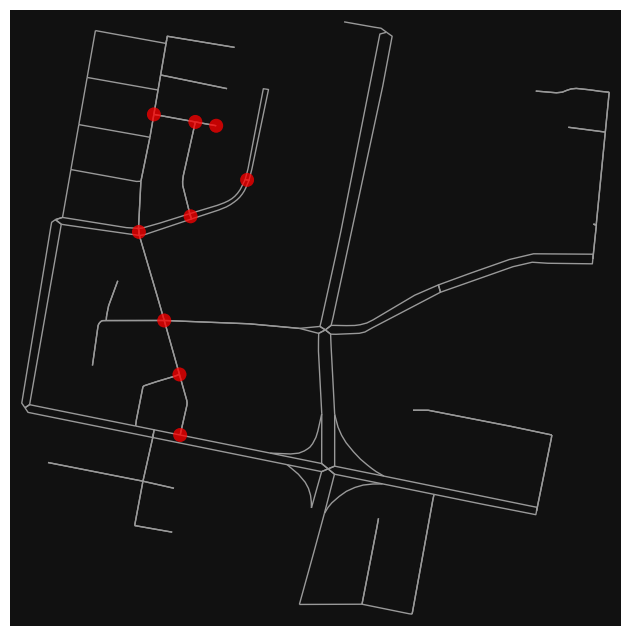

In [11]:
route
routes_g = []
for n in list(route.keys()):
    if len(route[n]) > 0:
        route_G = nx.shortest_path(G3, n, n)
        routes_g.append(route_G)

fig, ax = ox.plot_graph_routes(G3, routes_g, route_linewidth=6, node_size=0)

In [20]:
path

[25, 26, 25, 26, 27, 55, 52, 1, 46, 47, 1, 46, 47]